In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import numpy as np
import tqdm
import time
import h5py
import random

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from advertorch.attacks import GradientSignAttack
from torch.utils.tensorboard import SummaryWriter

In [47]:
import sys
sys.path.append("../src/")

from ubs8k.datasetManager import DatasetManager
from ubs8k.generators import Dataset
import ubs8k.signal_augmentations as signal_augmentations
from ubs8k.models import scallable2_new
from ubs8k.utils import get_datetime, reset_seed
from ubs8k.metrics import CategoricalAccuracy


In [161]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
from ipywidgets import interact, interactive, fixed, interact_manual
plt.style.use('dark_background')


In [55]:
with h5py.File("../dataset/audio/urbansound8k_22050_augmentations.hdf5", "r") as hdf:
        one_file_aug = hdf["fold1"]
        print(one_file_aug["N2"].shape)

(5, 873, 88200)


# Graphical UI

In [167]:
with h5py.File("../dataset/audio/urbansound8k_22050_augmentations.hdf5", "r") as hdf:
    print(np.asarray(hdf["fold1"].keys()))

OSError: Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [49]:
def check_pair(index=0, flavor=0, augmentation="PSC1"):
    print("Reading hdf file ...")
    with h5py.File("../dataset/audio/urbansound8k_22050_augmentations.hdf5", "r") as hdf:
        one_file_aug = np.asarray(hdf["fold1"][augmentation][flavor, index, :])
        print(hdf["fold1"]["filenames"][index])
    
    with h5py.File("../dataset/audio/urbansound8k_22050.hdf5", "r") as hdf:
        one_file_orig = np.asarray(hdf["fold1"]["data"][index, :])
        print(hdf["fold1"]["filenames"][index])
        
    print("Displaying ...")
    plt.figure(0, figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.title("Augmented signal")
    plt.plot(one_file_aug)

    plt.subplot(2, 2, 3)
    plt.title("Origianl signal")
    plt.plot(one_file_orig)

    plt.subplot(2, 2, 2)
    plt.title("Original mel spectrogram")
    librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(one_file_aug),  ref=np.max))

    plt.subplot(2, 2, 4)
    plt.title("Original mel spectrogram")
    librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(one_file_orig),  ref=np.max))
    plt.show()
    
    print("Playing")
    display.display(Audio(one_file_orig, rate=22050))
    display.display(Audio(one_file_aug, rate=22050))

Reading hdf file ...
103258-5-0-4.wav
103258-5-0-4.wav
Displaying ...


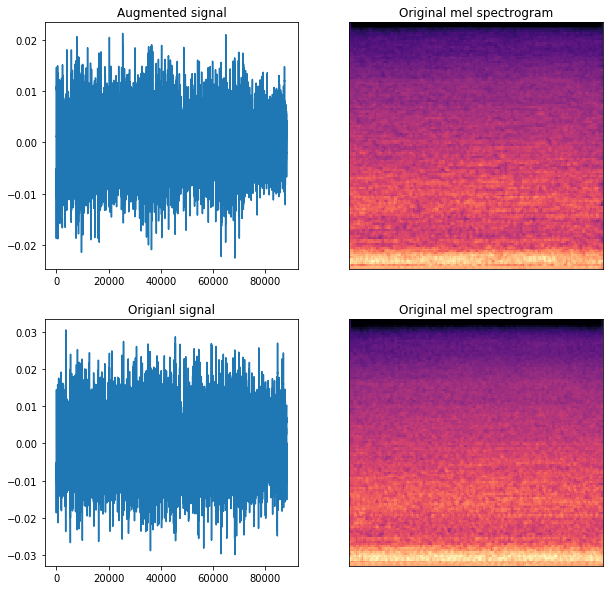

Playing


In [63]:
check_pair(50, 0, "PSC2")

# Plot mean and std for all files (can take some times)

In [140]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [163]:
from tqdm import trange

original_mean, original_std = [], []
with h5py.File("../dataset/audio/urbansound8k_22050.hdf5", "r") as hdf:
    for index in trange(hdf["fold1"]["data"].shape[0]):
        one_file_orig = np.asarray(hdf["fold1"]["data"][index, :])
        original_mean.append(np.mean(one_file_orig))
        original_std.append(np.std(one_file_orig))
        
augmented_mean, augmented_std = {}, {}
augmentation="PSC2"
flavor=0
with h5py.File("../dataset/audio/urbansound8k_22050_augmentations.hdf5", "r") as hdf:
    for flavor in range(2):
        augmented_mean[flavor] = []
        augmented_std[flavor] = []
        for index in trange(hdf["fold1"][augmentation].shape[1]):
            one_file_aug = np.asarray(hdf["fold1"][augmentation][flavor, index, :])
            augmented_mean[flavor].append(np.mean(one_file_aug))
            augmented_std[flavor].append(np.std(one_file_aug))

100%|██████████| 873/873 [00:02<00:00, 313.87it/s]


In [164]:
original_mean = np.asarray(original_mean)
original_std = np.asarray(original_std)

for flavor in range(2):
    augmented_mean[flavor] = np.asarray(augmented_mean[flavor])
    augmented_std[flavor] = np.asarray(augmented_std[flavor])

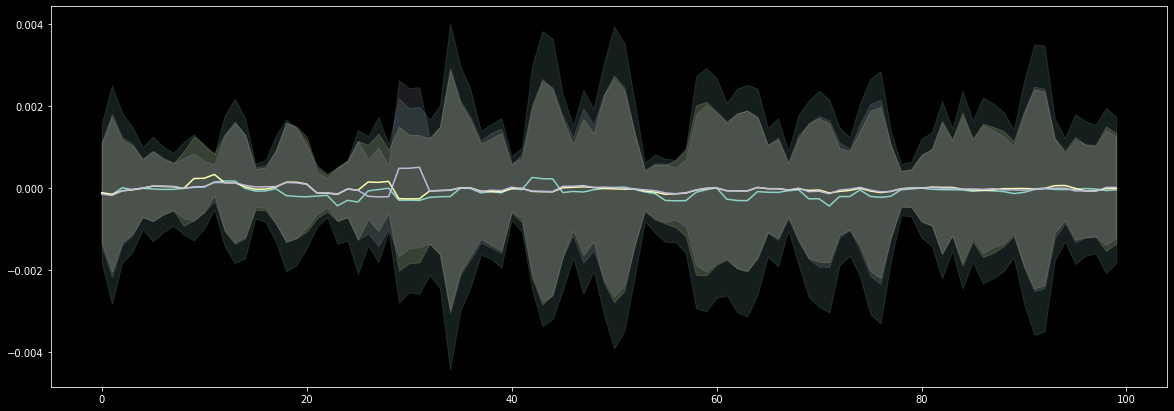

In [165]:
start=180
end=280
x = list(range(end-start))

display_ratio = 0.03
smooth_window = 3
om = smooth(original_mean[start:end], smooth_window)
ost = smooth(original_std[start:end] * display_ratio, smooth_window)
am1 = smooth(augmented_mean[0][start:end], smooth_window)
ast1 = smooth(augmented_std[0][start:end] * display_ratio, smooth_window)
am2 = smooth(augmented_mean[1][start:end], smooth_window)
ast2 = smooth(augmented_std[1][start:end] * display_ratio, smooth_window)


plt.figure(0, figsize=(20, 7))
plt.plot(x, om, color="C0")
plt.fill_between(x, om-ost, om+ost, color="C0", alpha=0.15)

plt.plot(x, am1, color="C1")
plt.fill_between(x, am1-ast1, am1+ast1, color="C1", alpha=0.15)

plt.plot(x, am2, color="C2")
plt.fill_between(x, am2-ast2, am2+ast2, color="C2", alpha=0.15)
plt.show()